In [1]:
# Importing the required libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from model import SimpleNN
from util import training_loop, show_images
from cnn import CNN         # Class that I defined of a Convolutional Neural Network

## Loading the data

In [2]:
# Load MNIST dataset (TensorFlow/Keras)
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images to the range [-1, 1]
])

# Load the MNIST dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Note: Running the above cell will create a new folder called 'data' in your working directory.
Let's visualize the images. (Defined a function called `show_images` in `util.py`)

In [5]:
#show_images(train_dataset)

## Calling the Model

The model architecture is defined in `model.py`, and the code below trains and tests the models.

In [ ]:
# Calling the model from model.py


Next steps:
1. Train the model (change architecture)
2. Hyperparameter finetuning (plot some graphs of different hyperparams vs time) and choose the final model on the validation set
3. Setup a framework (use `utils.py`) to import images from a different source (e.g manually imported images), and convert them to the required format to be fed into the model
4. If you want to be fancy setup a fancy interface for it (some frontend stuff?)
5. Create a requirements.txt file (generate automatically)

## Convolutional Neural Network

Research has shown that Convolutional Neural Networks are very good at dealing with image data because they are designed to capture spatial hierarchies adn patterns, which are crucial for understanding visual data. 

1. **Local Receptive Fields**: CNNs use small filters (kernels) that focus on local regions of an image. These filters help the network detect simple features like edges, corners or textures in small regions of the image. As the network deepends, it can combine these simple features to identify more complex patterns, such as shapes or objects. 
2. **Weight Sharing**: In CNNs, the same filter (set of weights) is used across different parts of an image. This weight sharing reduces the number of parameters in the model, making ti computationally efficient and allowing the network to generalize better across various positions in an image. 

### Loss Function
Cross Entropy loss is well suited for the MNIST dataset because it is designed for multi-class classification, where the goal is to predict one of the several classes (0-9). It pairs well with the softmax activation function, which outputs a probability distribution, and penalizes incorrect predictions by encouraging high confidence in the correct class. 

In [6]:
# Use the model architecture defined in the file cnn.py to train the model. 
# Use the same split of training data taken above.

# Hyperparameters
learning_rate = 0.001

#Initialize the model, loss function and optimizer
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [7]:
# Training loop

num_epochs = 5

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()

        outputs = cnn_model(images)             # Forward pass
        loss = criterion(outputs, labels)       # Compute the loss
        loss.backward()                         # Backward pass and optimize
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%')

Epoch [1/5], Loss: 0.1746, Accuracy: 94.72%
Epoch [2/5], Loss: 0.0517, Accuracy: 98.43%
Epoch [3/5], Loss: 0.0363, Accuracy: 98.85%
Epoch [4/5], Loss: 0.0280, Accuracy: 99.12%
Epoch [5/5], Loss: 0.0211, Accuracy: 99.31%


In [8]:
# Testing the model
cnn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 98.83%


In [9]:
# Save the trained model
torch.save(cnn_model.state_dict(), 'mnist_cnn.pth')

## Loading the model from a saved file

Run the code cells below once the model has already been trained and exported to a `.pth` file. 
This code will load the model from the file and run it on a sample of the MNIST dataset and print out the dataset and the predicted labels.

In [10]:
file_path = 'mnist_cnn.pth' #Replace this with the appropriate file name
pretrained_model = CNN()
pretrained_model.load_state_dict(torch.load(file_path))
pretrained_model.eval()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

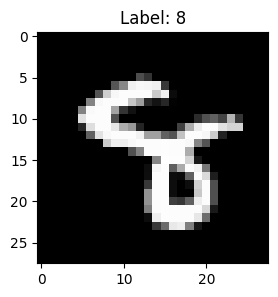

True Label: 8, Predicted Label: 8


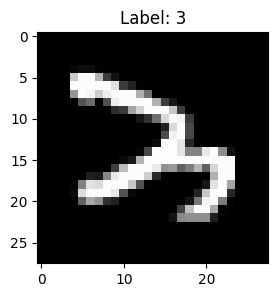

True Label: 3, Predicted Label: 2


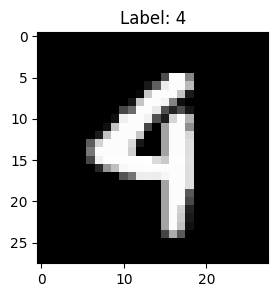

True Label: 4, Predicted Label: 9


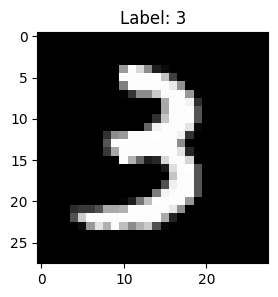

True Label: 3, Predicted Label: 3


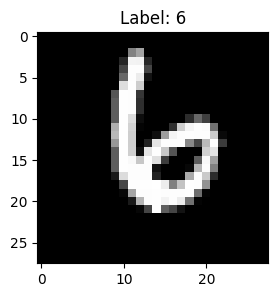

True Label: 6, Predicted Label: 6


In [16]:
# Taking a random sample from the test dataset
import random
import matplotlib.pyplot as plt

random_indexes = [random.randint(0, len(test_data)-1) for _ in range(5)]
for random_idx in random_indexes:
    image, label = test_data[random_idx]

    # Display the image and tis label
    image = image.squeeze()
    plt.figure(figsize=(3, 3))  # Adjust the size as needed
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()

    # Optionally, print the label and its predicted value from the model
    image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = pretrained_model(image)  # Forward pass through the model
        _, predicted = torch.max(output.data, 1)  # Get the predicted label

    print(f"True Label: {label}, Predicted Label: {predicted.item()}")